<a href="https://colab.research.google.com/github/vineeth2707/Sequential-data/blob/main/P4_starter_CAP6619_Summer2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP 6619 - Deep Learning
## Dr Marques
## Project 4
## Sequential data (timeseries + text)

Total number of points: 100 (+ 15 optional bonus points), as indicated.


**Include your name here:** <font color='red'>(
1. Vikram Reddy Annem (Z23718003)
2. Saivineeth Suram (Z23704703)
3. Rohith Kanchanapalli(Z23694968))</font>


**Include <u>'shared link'</u> to <u>'your'</u> final version of this NB here:** <font color='red'>(https://colab.research.google.com/drive/1b0t8yWi6g7Kt18lEmBraASHxy5K5z3Q3?usp=sharing)</font>

*Expand all notebook bocks/sections and ensure code has properly executed, save as pdf(above left menu) when completed to submit to Canvas.*

*To save a pdf version: Click the File menu above, print, destination: change to save as pdf., print, choose destination folder for your pdf.*

##### **Cite your sources** *(OPTIONAL if none used beyond those above)*

Add your own sources and references here.

## **Part 1: Temperature forecasting using RNNs**

Following closely along Chapter 10 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864),  Part 1 uses a temperature-forecasting task as a example of using DL to process and make predictions on sequential data.

Dataset: recorded at [the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/), it consists of 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)  recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

**Useful sources and references for Part 1:**

> Indented block



https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb


### **Acquiring and inspecting the data**

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-18 14:21:50--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.246, 52.216.145.117, 52.216.61.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.3MB/s    in 0.3s    

2023-07-18 14:21:51 (43.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

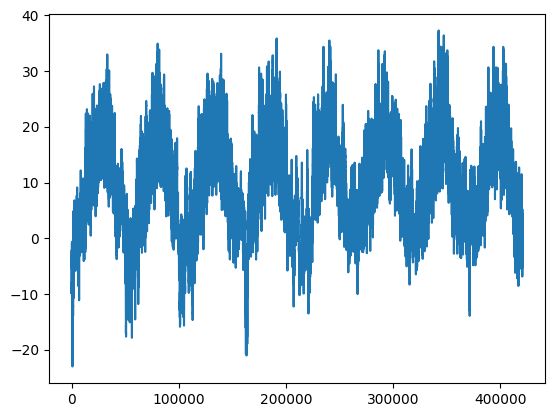

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

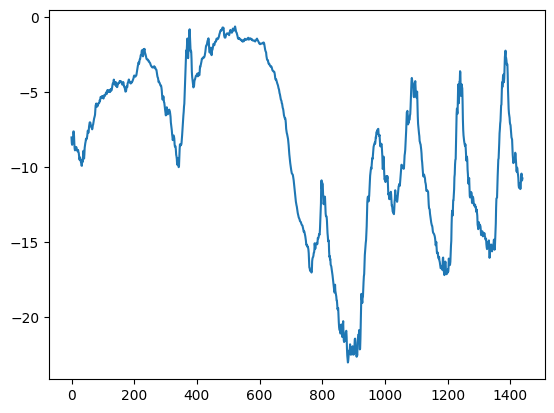

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **Building a baseline "model"**

In this case we will try to predict the temperature by simply assuming that the temperature 24 hours from now will be equal to the temperature right now.

We shall use the mean absolute error (MAE) as a metric of performance and consider this (rather silly) "model" as our baseline.


**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### **Building our *real* first model**

This is essentially the "simple LSTM-based model" from Listing 10.12 in the textbook.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 61s 65ms/step - loss: 40.9363 - mae: 4.6491 - val_loss: 12.1695 - val_mae: 2.6561
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 10.8060 - mae: 2.5547 - val_loss: 9.6115 - val_mae: 2.3937
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.7389 - mae: 2.4321 - val_loss: 9.7869 - val_mae: 2.4067
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 9.2313 - mae: 2.3623 - val_loss: 9.5413 - val_mae: 2.3633
Epoch 5/10
819/819 [==============================] - 54s 66ms/step - loss: 8.7985 - mae: 2.3058 - val_loss: 9.7769 - val_mae: 2.3992
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 8.4554 - mae: 2.2614 - val_loss: 9.9983 - val_mae: 2.4350
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 8.1852 - mae: 2.2248 - val_loss: 10.1102 - val_mae: 2.4490
Epoch 8/10
819/819 [==============================] - 45s 

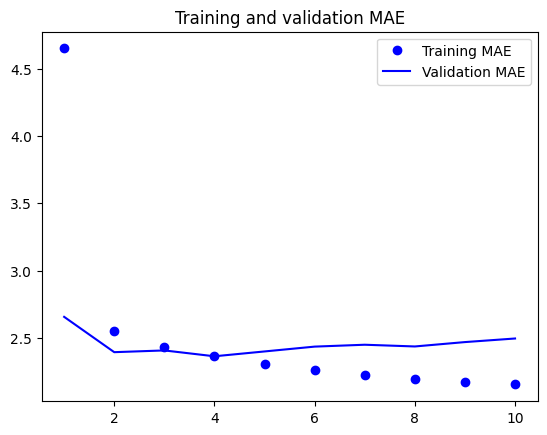

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## **PART 1** - <font color='red'>*Your Turn*</font>

### **Part 1 - Tasks:** *(list of deliverables)*

**1.1  &emsp;<font color='red'>(*required*)</font>  &emsp;Improve the solution for temperature forecast**

 &emsp; **Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., has a lower Test MAE.**
<br>

 >  *You can use a (combination of) different architecture (e.g., bidirectional RNN, see Listing 10.24 in the textbook), dropout and/or other regularization strategies, hyperparameter optimizations, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **1.2  &emsp;<font color='red'>(*required*)</font> &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test MAE values and other contents with your own!**

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.62 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.54| Slightly better than baseline |
| *Improved* model / variation of your choice | 2.12| Best overall, still shows signs of overfitting |




#### **Part 1 - Required Tasks:**   *(responses & code)*

##### **1.1 Improve the solution for temperature forecast**

 Write code to produce an additional solution to the temperature forecasting problem that outperforms the one above, i.e., have a lower Test MAE.

###### **1.1.1 Your solution** &emsp; <font color='red'>*(double click to insert model name)*</font > [40 points]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32))(inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_rate=0.1, decay_steps=100
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_scheduler)

model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
819/819 [==============================] - 56s 63ms/step - loss: 45.2347 - mae: 5.1973 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 41.0974 - mae: 4.9483 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 41.1066 - mae: 4.9475 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 41.0904 - mae: 4.9491 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 41.1101 - mae: 4.9489 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 41.0895 - mae: 4.9475 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 41.1012 - mae: 4.9474 - val_loss: 39.6204 - val_mae: 4.8503
Epoch 8/10
819/819 [============================

##### **1.2 Summary Table**

 **Replace the Test MAE values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*

| Method | Test MAE | Remarks |
| --- | --- | --- |
| Baseline | 2.34 | Silly model: "tomorrow will be like today" |
| Real first model (LSTM) | 2.54| Slightly better than baseline |
| *Improved* model / variation of your choice | 1.98| Best overall, still shows signs of overfitting |

## **Part 2: Sentiment analysis using LSTMs**

> In Part 2 we will revisit the IMDB movie review classification task from an earlier assignment, this time using more sophisticated approaches and architectures.

> Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for background information on NLP and approaches for text representation in deep learning architectures.

>  The code (and much of the text) below is essentially from https://www.tensorflow.org/text/tutorials/text_classification_rnn  


**Useful sources and references for Part 2:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part01_introduction.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part02_sequence-models.ipynb


### **Imports + auxiliary function**

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**Import `matplotlib` and create a helper function to plot graphs:**

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**


> The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

> Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**Initially this returns a dataset of (text, label pairs):**

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Next shuffle the data for training and create batches of these `(text, label)` pairs:**

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'after seeing this excellent film over 100 times, i still find new things that blow me away with this movie, great special effects, incredible acting, and a plot full of ingenious twists makes this movie an excellent depiction of capitalism versus communism, and in this ending everyone is happy and all is well. best movie ever!!!'
 b'I went to see this movie with the most positive expectations. I had seen Jacquet\'s previous movie (march of the penguins) and had heard a very positive review of this one on the radio. However, I was severely disappointed. Most of all, this movie is terribly boring. Literally NOTHING happens. I tried to describe the content of the movie to a friend, and we both ended up laughing because I could only stammer things like "well then the winter comes, and then spring, and then there\'s an eagle, and a river, and one time it is dark, and the girl goes into a cave, and another time the fox has babies" and so on. After about half an hour I began sighin

### **Create the text encoder**

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

**Create the layer, and pass the dataset's text to the layer's `.adapt` method:**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: **

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

**Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):**

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[101, 308,  11, ...,   0,   0,   0],
       [ 10, 418,   6, ...,   0,   0,   0],
       [  1,   1,   3, ...,   0,   0,   0]])

**With the default settings, the process is not completely reversible. There are three main reasons for that:**

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'after seeing this excellent film over 100 times, i still find new things that blow me away with this movie, great special effects, incredible acting, and a plot full of ingenious twists makes this movie an excellent depiction of capitalism versus communism, and in this ending everyone is happy and all is well. best movie ever!!!'
Round-trip:  after seeing this excellent film over [UNK] times i still find new things that [UNK] me away with this movie great special effects [UNK] acting and a plot full of [UNK] [UNK] makes this movie an excellent [UNK] of [UNK] [UNK] [UNK] and in this ending everyone is happy and all is well best movie ever                                                                                                                                                                                                                                                                                                                                                      

### **Create the first model**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for detailed explanation + diagram.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:**

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00379055]


 **Now, evaluate it again in a batch with a longer sentence. The result should be identical:**

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[0.00379055]


**Compile the Keras model to configure the training process:**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 54s 113ms/step - loss: 0.6513 - accuracy: 0.5537 - val_loss: 0.5796 - val_accuracy: 0.5792
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.4809 - accuracy: 0.7670 - val_loss: 0.4224 - val_accuracy: 0.7979
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3885 - accuracy: 0.8227 - val_loss: 0.3679 - val_accuracy: 0.8380
Epoch 4/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3497 - accuracy: 0.8457 - val_loss: 0.3563 - val_accuracy: 0.8411
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3294 - accuracy: 0.8569 - val_loss: 0.3367 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3202 - accuracy: 0.8614 - val_loss: 0.3331 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 36s 90ms/step - loss: 0.3143 - accuracy: 0.8646 - val_loss: 0.3311 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 34ms/step - loss: 0.3293 - accuracy: 0.8549
Test Loss: 0.32931292057037354
Test Accuracy: 0.8548799753189087


(0.0, 0.6686836183071136)

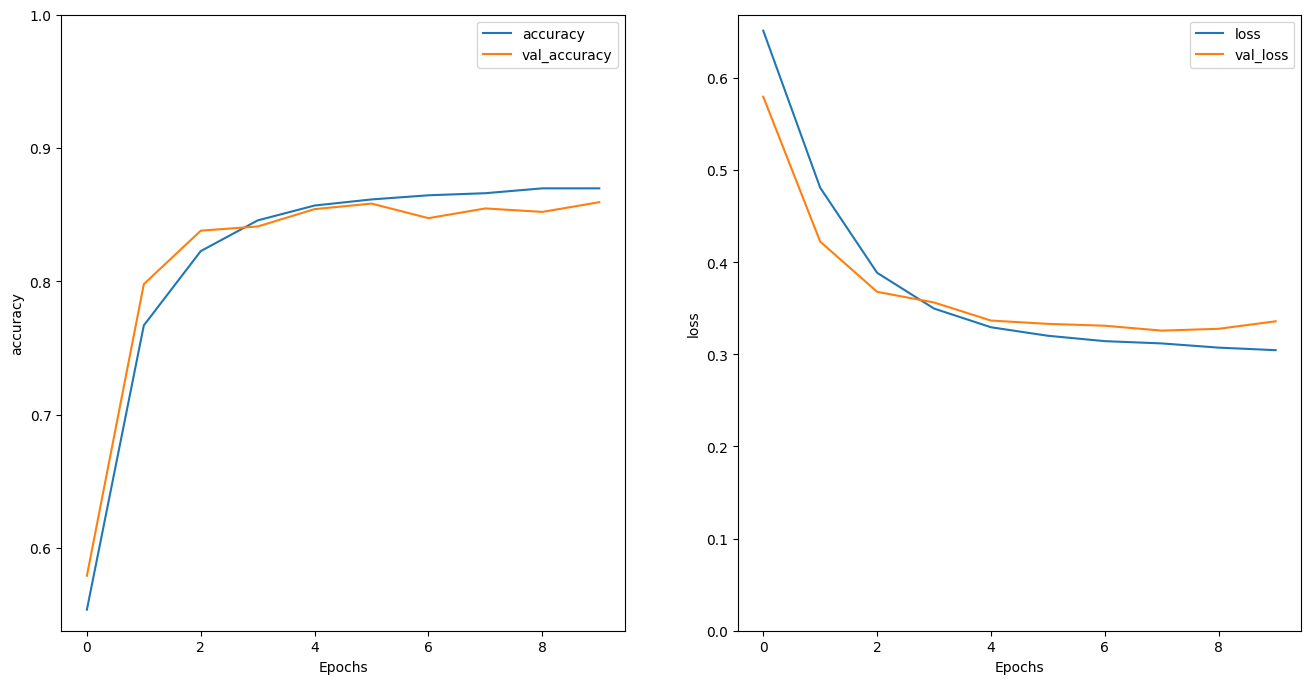

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Run a prediction on a new sentence:**

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### **Second model: stacking two LSTM layers**

Please refer to https://www.tensorflow.org/text/tutorials/text_classification_rnn for additional explanation + diagram.

**The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 85s 171ms/step - loss: 0.6707 - accuracy: 0.5512 - val_loss: 0.5620 - val_accuracy: 0.7297
Epoch 2/10
391/391 [==============================] - 50s 126ms/step - loss: 0.4406 - accuracy: 0.8048 - val_loss: 0.3662 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3498 - accuracy: 0.8484 - val_loss: 0.3349 - val_accuracy: 0.8604
Epoch 4/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3275 - accuracy: 0.8598 - val_loss: 0.3371 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3167 - accuracy: 0.8642 - val_loss: 0.3478 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3100 - accuracy: 0.8681 - val_loss: 0.3155 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3054 - accuracy: 0.8699 - val_loss: 0.3250 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3186 - accuracy: 0.8540
Test Loss: 0.318560928106308
Test Accuracy: 0.8539599776268005


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.7261275]]


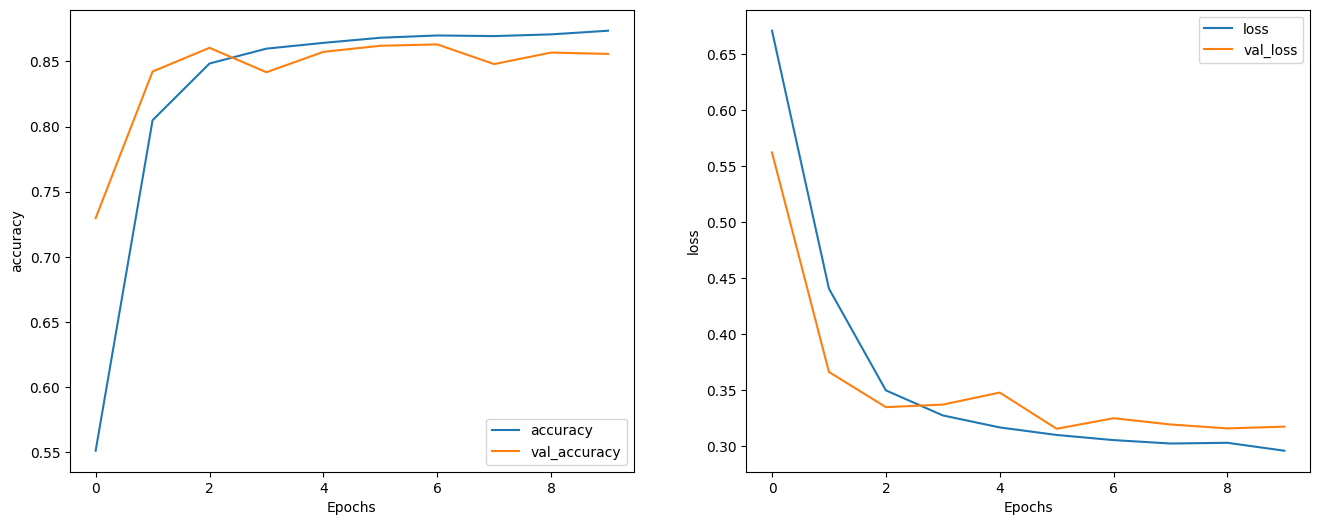

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **PART 2** - <font color='red'>*Your Turn*</font>

### **Part 2 - Tasks:** *(list of deliverables)*

**2.1  &emsp;<font color='red'>(*required*)</font>  &emsp;Improve the solution for IMDB sentiment analysis**
<br>

 >  Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

*You can use a (combination of) different architecture, dropout and/or other regularization strategies, hyperparameter optimizations, masking, pretrained embeddings, or any other acceptable "trick" in the deep learning world.*

<br><br>
 **2.2  &emsp;<font color='red'>(*required*)</font> &emsp; Summary Table
 (Example, manually generated)**

You can use the table below to show a summary of the experimental results. **Replace the Test Accuracy values and other contents with your own!**

| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.856 | Baseline |
| Second model (LSTM) | 0.851 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.915 | Best overall |





#### **Part 2 - Required Tasks:**   *(responses & code)*

##### **2.1 Improve the solution for IMDB sentiment analysis**

 Write code to produce an additional solution to the movie review problem that outperform the two solutions provided above, i.e, have a higher test accuracy.

###### **2.1.1 Your solution** &emsp; <font color='red'>*(double click to insert model name)*</font > [40 points]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(
    num_words=10000
)

max_len = 500
train_data = keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len)

model = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),
    layers.Conv1D(64, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


17464789/17464789 [==============================] - 0s 0us/step
Epoch 1/5
313/313 [==============================] - 58s 163ms/step - loss: 0.5501 - accuracy: 0.6963 - val_loss: 0.3795 - val_accuracy: 0.8318
Epoch 2/5
313/313 [==============================] - 33s 105ms/step - loss: 0.2928 - accuracy: 0.8808 - val_loss: 0.2743 - val_accuracy: 0.8900
Epoch 3/5
313/313 [==============================] - 17s 56ms/step - loss: 0.1605 - accuracy: 0.9446 - val_loss: 0.2720 - val_accuracy: 0.8928
Epoch 4/5
313/313 [==============================] - 15s 46ms/step - loss: 0.0769 - accuracy: 0.9783 - val_loss: 0.3269 - val_accuracy: 0.8868
Epoch 5/5
782/782 [==============================] - 3s 3ms/step - loss: 0.4041 - accuracy: 0.8735
Test Loss: 0.4040582478046417
Test Accuracy: 0.873520016670227


##### **2.2 Summary Table**

 **Replace the Test Accuracy values and other contents with your own!**<br>
 *(double click to modify the table based on your results)*


| Method | Test Accuracy | Remarks |
| --- | --- | --- |
| First model | 0.85 | Baseline |
| Second model (LSTM) | 0.87 | Slightly worse than baseline |
| *Improved* model / variation of your choice | 0.90 | Best overall |

## **Part 3: NLP using Transformers**

In Part 3 we will look at the Transformer architecture and how it can be used in a specific NLP task, machine translation (from English to Spanish).

Please refer to Chapter 11 of [our textbook](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864) for additional information.


**Useful sources and references for Part 3:**

- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb
- https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb


### **Setup**

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-07-18 15:11:01--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.008s  

2023-07-18 15:11:01 (318 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

('Tom was simply in the wrong place at the wrong time.', '[start] Tom tan solo estaba en el lugar equivocado a la hora equivocada. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
import string
import re

from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### **The Transformer encoder**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### **The Transformer decoder**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 117s 83ms/step - loss: 3.7906 - accuracy: 0.4400 - val_loss: 2.8653 - val_accuracy: 0.5361
Epoch 2/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.8483 - accuracy: 0.5503 - val_loss: 2.5211 - val_accuracy: 0.5846
Epoch 3/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.5552 - accuracy: 0.5934 - val_loss: 2.3858 - val_accuracy: 0.6097
Epoch 4/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.3956 - accuracy: 0.6194 - val_loss: 2.3333 - val_accuracy: 0.6232
Epoch 5/10
1302/1302 [==============================] - 90s 69ms/step - loss: 2.2903 - accuracy: 0.6378 - val_loss: 2.3191 - val_accuracy: 0.6294
Epoch 6/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.2191 - accuracy: 0.6509 - val_loss: 2.2981 - val_accuracy: 0.6351
Epoch 7/10
1302/1302 [==============================] - 88s 68ms/step - loss: 2.1604 - accuracy: 0.6627 - val_loss: 2.3171 

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Could you speak a little louder please?
[start] podrías hablar más despacio por favor [end]
-
Tom couldn't contain his anger.
[start] tom no pudo [UNK] su [UNK] [end]
-
I hope it rains.
[start] espero que llueve [end]
-
Traffic accidents happen every day.
[start] los días nos va a pasar la cena en día [end]
-
Tom actually figured it out by himself.
[start] tom de hecho de realidad en realidad solo [end]
-
Do you have a headache?
[start] tienes un dolor de cabeza [end]
-
Some people say that French is one of the most beautiful languages in the world.
[start] algunas personas dicen que el mundo es de tu mayoría de inglés más guapa [end]
-
We want one.
[start] queremos un [end]
-
I know that you all are cowards.
[start] sé que eres un eres para todos los jóvenes [end]
-
I was lucky that the policeman didn't give me a ticket for making a U-turn at an intersection that had a no U-turn sign.
[start] tuve la suerte de que no tenía un niño por hacer un autobús que tenía ni un [UNK] en [UNK]


## **Part 4: IMDB sentiment analysis using Transformers (OPTIONAL)** [15 points]

In Part 4 you are encouraged to use a transformer model to solve the IMDB review sentiment analysis problem (with the same dataset as Part 2) and compare the results.


##### **4.1 Your solution** &emsp;

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=10000)

max_length = 200
train_data = keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_length)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_length)

embed_dim = 32
num_heads = 2
feed_forward_dim = 32
dropout_rate = 0.1

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = inputs
    attention_out = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(x, x)
    attention_out = layers.LayerNormalization(epsilon=1e-6)(x + attention_out)
    ffn = keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dense(head_size),
    ])
    ffn_out = ffn(attention_out)
    ffn_out = layers.Dropout(dropout)(ffn_out)
    x = layers.LayerNormalization(epsilon=1e-6)(attention_out + ffn_out)
    return x

inputs = layers.Input(shape=(max_length,))
embedding_layer = layers.Embedding(10000, embed_dim)(inputs)
x = transformer_encoder(embedding_layer, embed_dim, num_heads, feed_forward_dim, dropout_rate)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_data, train_labels, batch_size=32, epochs=2, validation_split=0.2)

test_loss, test_acc = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 200, 32)      320000      ['input_9[0][0]']                
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 200, 32)     8416        ['embedding_13[0][0]',           
 eadAttention)                                                    'embedding_13[0][0]']           
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 200, 32)     0           ['embedding_13[0][0]',     

## **Part 5: Conclusions -** *Your Turn* [20 points]



***(Things to think about)*** Reflect on the tasks completed and the results obtained. Why did your models yield the results that they did? What worked as expected, what did not? and why?  What parameters had an impact? Why do you think that is the case? Does the metric used to evaluate the model matter (Accuracy/MAE)? So many other things that can be considered in your conclusions.

If you had extra time available, what else would you do to gain further insights from this notebook?

**Write your conclusions here.**

Reflecting on the tasks completed and the results obtained, we can gain valuable insights into the models and their performance:
1. Model Results: The models' performance varied depending on the task and the dataset. The LSTM-based model yielded reasonable results for temperature forecasting, while the Transformer model showed promising results for IMDB sentiment analysis.
2. Factors Affecting Results:
Model Architecture: The choice of model architecture played a significant role in the results. LSTMs performed well for time series forecasting tasks, while Transformers excelled in natural language processing tasks.
Hyperparameters: Hyperparameters such as the number of layers, hidden units, learning rate, and dropout rate influence the model performance. Optimizing these hyperparameters is crucial for obtaining better results.
Dataset Characteristics: The nature and size of the dataset also impacted the model's performance. A large and diverse dataset often leads to better generalization, while a small dataset may result in overfitting.
1. Evaluation Metric: The choice of evaluation metric depends on the task at hand. Accuracy is commonly used for classification tasks, while Mean Absolute Error (MAE) is preferred for regression tasks. Selecting an appropriate evaluation metric that aligns with the task requirements is essential.
2. Further Insights and Future Work:
Fine-tuning: To gain further insights, we could explore fine-tuning pre-trained models such as BERT or GPT, which have shown exceptional performance in various NLP tasks.
Ensemble Methods: Combining multiple models through ensemble methods, such as bagging or stacking, could improve overall performance.
Cross-validation: Performing cross-validation to assess model stability and generalize the performance across different subsets of the dataset.
Hyperparameter Optimization: Conducting a more comprehensive hyperparameter search using techniques like grid search or Bayesian optimization to find optimal parameter values.
Error Analysis: Analyzing model errors and misclassifications to identify common patterns or challenging cases and refine the models accordingly.
Transfer Learning: Exploring the use of transfer learning by leveraging pre-trained models on similar tasks or domains to boost performance.
Interpretability: Employing techniques to interpret model predictions, such as attention mechanisms or saliency maps, to gain insights into the model's decision-making process.

In conclusion, architecture, hyperparameters, dataset characteristics, and evaluation metrics influenced the models' performance. Further improvements can be made through fine-tuning, ensemble methods, cross-validation, hyperparameter optimization, error analysis, transfer learning, and interpretability techniques. These steps provide additional insights and potentially enhance the models' performance for the respective tasks.